## Descriptive Analysis

A notebook to describe the data set with simple statistical tools.

In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_rel
from sklearn.preprocessing import KBinsDiscretizer
import random

# to import ml_colon
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src')) 

import ml_colon

### Setting up Data Directory

In [2]:
data_dir = ml_colon.HERE.parents[2] / "data" 
print(data_dir)

assert data_dir.exists()

data_files = list(data_dir.glob("*.csv"))
print([f.name for f in data_files])

assert data_files

/Users/nacho/Desktop/DP Project/data_processes_mlcolonoscopy-main/notebooks/../data
['raw_data.csv', 'data_description.csv']


### Loading Raw Data

In [3]:
_filepath = data_dir / "raw_data.csv"
df = pd.read_csv(_filepath)

# assert all rows have been loaded
len(df) == sum(1 for i in open(_filepath)) -1 # file has header

print(f"Raw data set has: {len(df)} rows")

Raw data set has: 16000 rows


In [4]:
descr_df = pd.read_csv(data_dir / "data_description.csv", index_col="column_name")

In [5]:
print(descr_df)

                                                         description
column_name                                                         
quality              a measure of the quality of the recorded video.
bits               number of bits used to encode that block in th...
intra_parts        number sub-blocks inside this block that are n...
skip_parts         number sub-blocks inside this block that are s...
inter_16x16_parts  number of sub-blocks inside this block making ...
inter_4x4_parts    number of sub-blocks inside this block making ...
inter_other_parts  number of sub-blocks inside this block making ...
non_zero_pixels    number of pixels different from 0 after encodi...
frame_width                  the width of the video frame in pixels.
frame_height                the height of the video frame in pixels.
movement_level     a measure of the level of movement of this fra...
mean                        mean of the pixels of the encoded block.
sub_mean_1         mean of the pix

Let's take a quick look at the actual data.

In [6]:
df.head()

,quality,bits,intra_parts,skip_parts,inter_16x16_parts,inter_4x4_parts,inter_other_parts,non_zero_pixels,frame_width,frame_height,...,sobel_h,sobel_v,variance,block_movement_h,block_movement_v,var_movement_h,var_movement_v,cost_1,cost_2,relevant
0,22,2143,0,0,1,3,21,404,416,240,...,17.397461,17.397461,87.584335,2.820312,2.539062,10.772400,8.576599,0.0,0.0,1.0
1,22,1735,0,2,0,3,8,381,416,240,...,14.426758,14.233398,48.025330,1.843750,1.921875,6.163086,6.665771,8816.0,8801.0,1.0
2,22,1971,0,0,0,0,8,460,416,240,...,15.203125,13.953125,56.613480,3.000000,4.937500,1.625000,3.683594,5104.0,5193.0,1.0
3,22,2473,0,0,0,18,20,421,416,240,...,21.725586,29.165039,283.079285,2.078125,2.500000,25.806396,34.656250,21531.0,19802.0,1.0
4,22,1093,0,0,1,3,8,167,416,240,...,11.929688,14.353516,175.123245,3.070312,4.523438,22.252869,14.780701,15073.0,14549.0,1.0


Let's take a quick look at the datatypes in the dataframe

In [7]:
df.dtypes

quality                int64
bits                   int64
intra_parts            int64
skip_parts             int64
inter_16x16_parts      int64
inter_4x4_parts        int64
inter_other_parts      int64
non_zero_pixels        int64
frame_width            int64
frame_height           int64
movement_level         int64
mean                 float64
sub_mean_1           float64
sub_mean_2           float64
sub_mean_3           float64
sub_mean_4           float64
var_sub_blocks       float64
sobel_h              float64
sobel_v              float64
variance             float64
block_movement_h     float64
block_movement_v     float64
var_movement_h       float64
var_movement_v       float64
cost_1               float64
cost_2               float64
relevant             float64
dtype: object

Conclusion:
Looks like we are only dealing with numerical data (no characters, strings, datetimes, ...)

However, the int64 types seem to be discrete and may need special care.

### Missing Values?

Next, let's take a look if there are any Nulls, NaNs in the data set and if so how many.

In [8]:
_null_df = df.isnull().sum()

print(_null_df[_null_df > 0])

sub_mean_3    14
cost_2        17
relevant       2
dtype: int64


The missing values for sub_mean_3 and cost_2 maybe can be imputed / recovered. (or dropped since there are only 17 at most)

For the target variable "relevant" not. It's probably best to drop these 2 rows as we later also want to exclude them from training / testing the model and its only a total of 2 rows...

In [9]:
df = df[~df.relevant.isnull()]

len(df)

15998

### Column Analysis

We want to go over each variable in the dataset and explore it with simple descriptive statistics.

A first overview can be seen here:

In [10]:
df.describe()

,quality,bits,intra_parts,skip_parts,inter_16x16_parts,inter_4x4_parts,inter_other_parts,non_zero_pixels,frame_width,frame_height,...,sobel_h,sobel_v,variance,block_movement_h,block_movement_v,var_movement_h,var_movement_v,cost_1,cost_2,relevant
count,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,...,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15981.000000,15998.000000
mean,29.500938,449.697400,11.041380,0.849294,0.995499,1.977997,3.685273,74.059007,1432.075009,850.046256,...,8.027204,8.270743,53.333526,8.024506,6.797750,842.053206,491.974570,36943.436492,42055.148051,0.822353
std,5.590065,549.099212,19.051407,1.181890,1.018540,3.901329,4.445079,102.584098,851.931382,530.222216,...,9.184985,9.552621,107.271594,17.260686,11.552863,3815.457401,2404.213566,38630.539744,43844.993440,0.382227
min,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,416.000000,240.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,520.000000,300.000000,...,0.896240,0.943359,1.424382,0.500000,0.500000,0.687500,0.746094,9916.250000,10964.000000,1.000000
50%,32.000000,243.000000,0.000000,0.000000,1.000000,0.000000,2.000000,33.000000,1920.000000,1080.000000,...,5.170898,5.313477,14.525076,2.625000,3.214844,11.685547,19.544434,23048.500000,26132.000000,1.000000
75%,35.750000,622.000000,16.000000,1.000000,2.000000,3.000000,6.000000,100.000000,2400.000000,1470.000000,...,11.628906,11.776123,52.494077,7.062500,8.062500,94.125549,96.068176,52043.250000,59856.000000,1.000000
max,37.000000,4771.000000,64.000000,4.000000,4.000000,33.000000,27.000000,828.000000,2560.000000,1600.000000,...,69.706055,66.775391,2022.197998,322.093750,189.000000,194634.750000,68389.359375,425705.000000,446306.000000,1.000000


#### Column: Quality

In [11]:
column_name = "quality"
print(descr_df.loc[column_name, "description"])

sns.histplot(df[column_name].values)

a measure of the quality of the recorded video.


AttributeError: module 'seaborn' has no attribute 'histplot'

In [12]:
df[column_name].value_counts()

37    4000
27    4000
32    4000
22    3998
Name: quality, dtype: int64

Looks like a Discrete uniform distribution, but maybe data set was sampled in that way...


#### Column: Bits

In [ ]:

column_name = "bits"
print(descr_df.loc[column_name, "description"])

In [ ]:

fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")

sns.histplot(df[column_name].values, ax=ax)

The distribution is highly skewed and it looks like most of the blocks are encoded using only a few bits.
This raises the question: Are there blocks that allegedly are encoded with 0 bits in the video stream?

Note: This should not be possible as 0 bits would mean 0 information in my opinion. 

Let's identify the characteristics of the rows whose value of "bits" is 0

In [ ]:
df[df["bits"]==0].head()

In [ ]:
df[df["bits"]==0].sum()

When the value of <i>bits</i> is 0, <i>intra_parts, inter_16x16_parts, inter_4x4_parts, inter_other_parts, non_zero_pixels, block_movement_h, block_movement_v, var_movement_h, var_movement_v</i> are zero as well. So, what do they represent?

In [ ]:
pd.options.display.max_colwidth = 200
descr_df.loc[df[df["bits"]==0].sum()==0]

In [ ]:
print("Number of rows with 0 bits: ", len(df[df[column_name] ==0]))

In [ ]:
pd.cut(df[column_name], bins=[0, 8, 16, 32, 64, 124], include_lowest=False).value_counts(sort=False)

There are some block that are encoded with a very small number of bits. 696 rows are encoded with at most 8 bits. Will be interesting to see how quality depends on number of bits...For now we keep these rows but potentially these rows we have to deal with separately.

#### intra_parts

In [ ]:
column_name = "intra_parts"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")

sns.histplot(df[column_name].values, ax=ax)

In [ ]:
df[column_name].value_counts(sort=False)

The big majority of rows have 0 sub-blocks. Not sure if I yet understand what these sub-blocks are...

#### skip_parts

In [ ]:
column_name = "skip_parts"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

In [ ]:
df.columns

#### inter_16x16_parts

In [ ]:
column_name = "inter_16x16_parts"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

This is difficult to interpret. The description is not clear. 

#### Column: inter_4x4_parts

In [ ]:
column_name = "inter_4x4_parts"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

The above two plots have shown that bigger sub-blocks have less information overlap than small sub-blocks. 

#### inter_other_parts

In [ ]:
column_name = "inter_other_parts"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### non_zero_pixels

In [ ]:
column_name = "non_zero_pixels"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### frame_width

In [ ]:
column_name = "frame_width"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### frame_height

In [ ]:
column_name = "frame_height"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### movement_level

In [ ]:
column_name = "movement_level"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### mean

In [ ]:
column_name = "mean"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sub_mean_1

In [ ]:
column_name = "sub_mean_1"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sub_mean_2

In [ ]:
column_name = "sub_mean_2"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sub_mean_3

In [ ]:
column_name = "sub_mean_3"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sub_mean_4

In [ ]:
column_name = "sub_mean_4"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### var_sub_blocks

In [ ]:
column_name = "var_sub_blocks"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sobel_h

In [ ]:
column_name = "sobel_h"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sobel_v

In [ ]:
column_name = "sobel_v"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### variance

In [ ]:
column_name = "variance"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### block_movement_h

In [ ]:
column_name = "block_movement_h"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### block_movement_v

In [ ]:
column_name = "block_movement_v"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### var_movement_h

In [ ]:
column_name = "var_movement_h"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### var_movement_v

In [ ]:
column_name = "var_movement_v"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### cost_1

In [ ]:
column_name = "cost_1"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### cost_2

In [ ]:
column_name = "cost_2"
print(descr_df.loc[column_name, "description"])

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

### Target variable: relevant 

In [ ]:
column_name = "relevant"
print(descr_df.loc[column_name, "description"])

In [ ]:
print("Relevant == 1: ", len(df[df.relevant == 1]))
print("Relevant == 0: ", len(df[df.relevant == 0]))

print("Percentage where relevant is 1 out of all: ",len(df[df.relevant == 1])/ len(df))

Conclusion of relevant:

There is a high difference in the number of relevant blocks and irrelevant blocks. In the machine learning we may need to stratify the data to not favor the algorithm of predicting 1 all the time. If we do not take this into account, we can create a very simple algorithm already with 82% accuracy (just predict 1 all the time).

As the outcome variable is binary, we should look into methods of classification, e.g. logistic regression / decision tree / neural networks

In order to consider which variables should be constant and categorical we explore the number of unique values of each of them

In [13]:
df.nunique()

quality                  4
bits                  2105
intra_parts             15
skip_parts               5
inter_16x16_parts        5
inter_4x4_parts         12
inter_other_parts       28
non_zero_pixels        568
frame_width              4
frame_height             4
movement_level         205
mean                  6598
sub_mean_1            3123
sub_mean_2            3022
sub_mean_3            3072
sub_mean_4            2975
var_sub_blocks       11455
sobel_h               9907
sobel_v               9894
variance             11999
block_movement_h      2368
block_movement_v      2221
var_movement_h        8426
var_movement_v        8449
cost_1               14377
cost_2               14536
relevant                 2
dtype: int64

We split into continuous and constant variables

In [14]:
cat = df.loc[:, df.nunique() < 29]
cont = df.loc[:, df.nunique() >= 29]
varlist = cont.columns.tolist()
varlist.append('relevant')
contRelv = df[varlist]

In [15]:
contRelv.groupby('relevant').mean()

,bits,non_zero_pixels,movement_level,mean,sub_mean_1,sub_mean_2,sub_mean_3,sub_mean_4,var_sub_blocks,sobel_h,sobel_v,variance,block_movement_h,block_movement_v,var_movement_h,var_movement_v,cost_1,cost_2
relevant,,,,,,,,,,,,,,,,,,
0.0,151.527094,21.776918,4.857270e+06,1.579388,1.772326,1.684585,1.589222,1.271418,4.234237,4.183534,4.216856,29.598292,7.685221,5.121575,977.899925,411.026926,30345.427164,34941.264344
1.0,514.109076,85.353147,3.856880e+06,3.874461,3.441059,3.225339,3.346922,3.189547,7.055798,8.857525,9.146477,58.460886,8.097799,7.159843,812.707176,509.461132,38368.758969,43593.241172


In this table we can check the difference between the relevant categories, which looks significative

In [16]:
def equality_testing(df, variables, y):
    for var in variables:
        group0 = df.loc[df[y] == 0][var].tolist()
        group1 = df.loc[df[y] == 1][var].tolist()
        print(var)
        # Some variables have different length depending the group
        maxSize = max(len(group0), len(group1))
        group0 = random.choices(group0, k = maxSize)
        group1 = random.choices(group1, k = maxSize)
        
        if ttest_rel(group0, group1).pvalue >= 0.5:
            print("The groups have the same mean.") 
        else:
            print("The groups are different.")

With this function we make use of the T-test in order to confirm if the groups are statistically different

In [17]:
equality_testing(contRelv, contRelv.columns[:-1].tolist(), contRelv.columns[-1])

bits
The groups are different.
non_zero_pixels
The groups are different.
movement_level
The groups are different.
mean
The groups are different.
sub_mean_1
The groups are different.
sub_mean_2
The groups are different.
sub_mean_3
The groups are different.
sub_mean_4
The groups are different.
var_sub_blocks
The groups are different.
sobel_h
The groups are different.
sobel_v
The groups are different.
variance
The groups are different.
block_movement_h
The groups are different.
block_movement_v
The groups are different.
var_movement_h
The groups are different.
var_movement_v
The groups are different.
cost_1
The groups are different.
cost_2
The groups are different.


Now we can see how the categorical variables correlate with the relevant variable

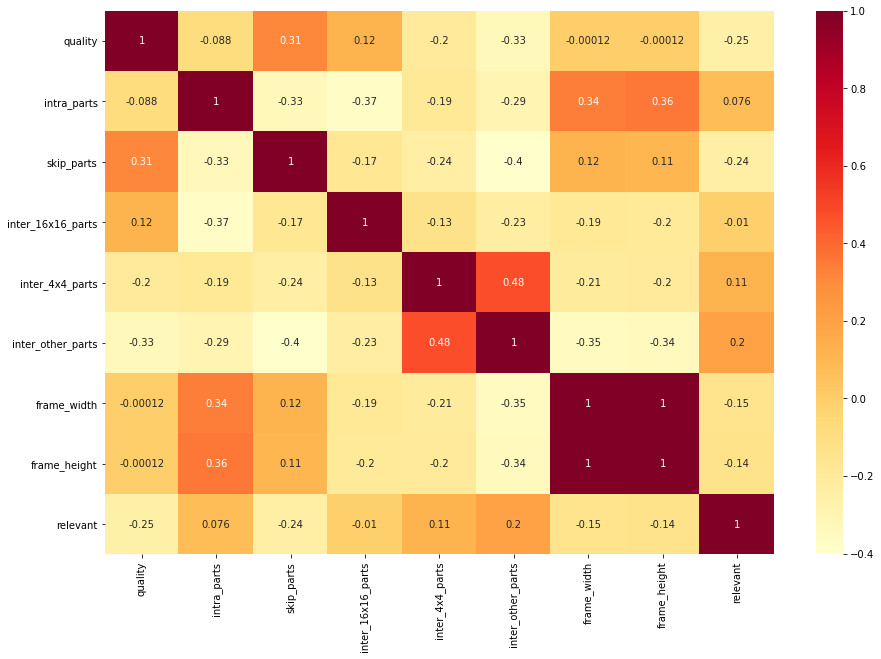

In [18]:
plt.figure(figsize = (15, 10))
corr_mtx = cat.corr()
sns.heatmap(corr_mtx, annot = True, cmap = "YlOrRd")

Now we do the same with the continuous variables

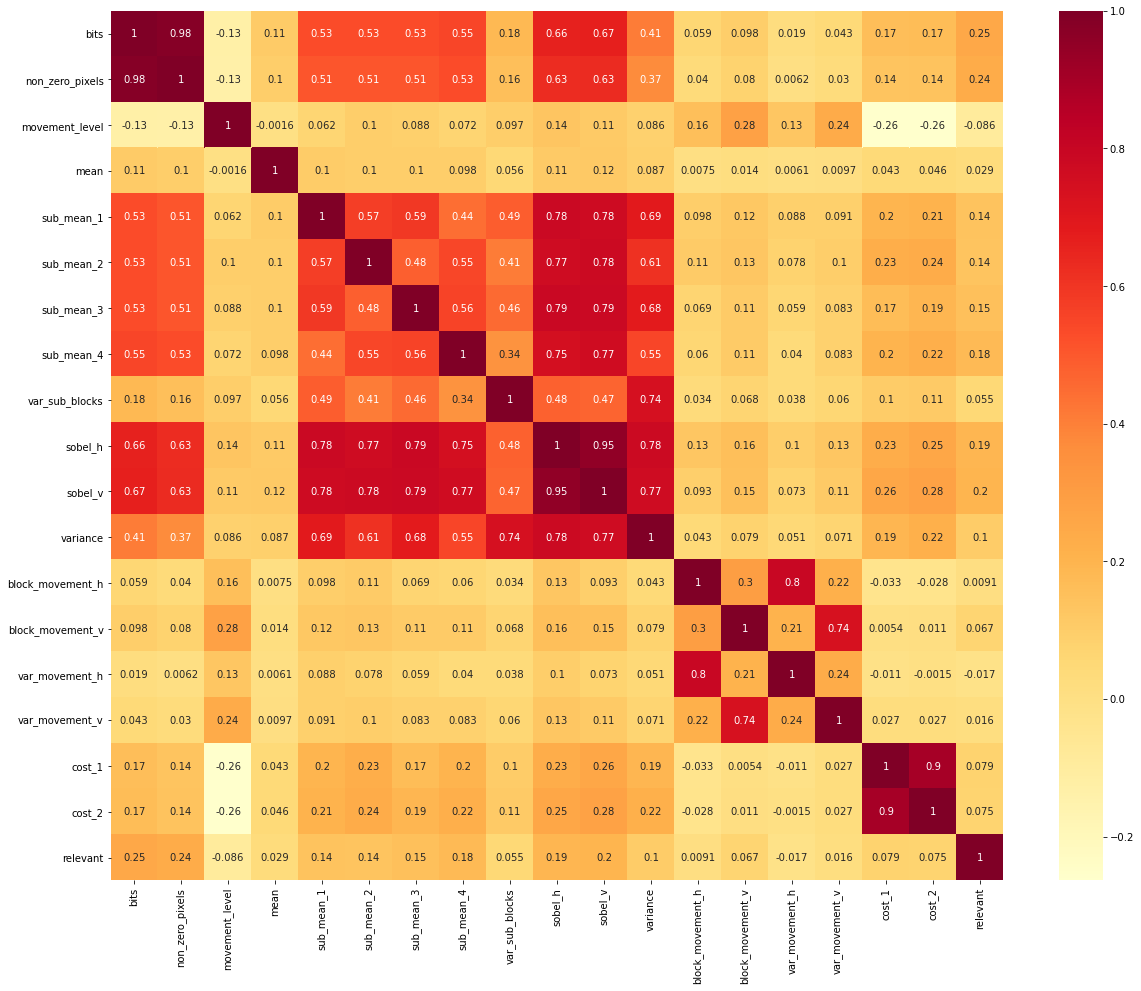

In [19]:
plt.figure(figsize = (20, 16))
corr_mtx = contRelv.corr()
sns.heatmap(corr_mtx, annot = True, cmap = "YlOrRd")

We reduce the number of variables in order to make a more comprenhensive correlation analysis.
Some of the variables are highly correlated and their descriptions help to understand how this reductions can me done. After creating new variables we delete the old ones.

In the first case we generate a new variable combining frame_height, frame_width and non_zero_pixels in order to obtain precise pixel infromation of the frame.

In [20]:
df["pixel_frame"] = (df['frame_height'] * df['frame_width']) / df['non_zero_pixels']

df = df.drop(['frame_height', 'frame_width', 'non_zero_pixels'], axis = 1)

For the sub_mean variable we have put all of them together in order to reduce their correlation.

In [21]:
df['sub_mean'] = (df['sub_mean_1'] + df['sub_mean_2'] + df['sub_mean_3'] + df['sub_mean_4']) / 4

df = df.drop(['sub_mean_1', 'sub_mean_2', 'sub_mean_3', 'sub_mean_4'], axis = 1)

The sobel variables make reference to the mean of the pixels of the encoded block after applying the Sobel operator in vertical and horizontal direction. So we can combine them easily in order to obtain a mean of both of them.

In [22]:
df['sobel_hv'] = (df['sobel_h'] + df['sobel_v']) / 2

df = df.drop(['sobel_h', 'sobel_v'], axis = 1)

This variables make reference to the measure of the movement and variance of a certain block in vertical and horizontal. As it is not relevant for this project to keep them separated we can obtain a single variable collecting a mean of this information.

In [23]:
df['movement_var'] = ((df['block_movement_h'] / df['var_movement_h']) + (df['block_movement_v'] / df['var_movement_v'])) / 2

df = df.drop(['block_movement_h', 'block_movement_v', 'var_movement_h', 'var_movement_v'], axis = 1)

We make the same combination with the cost variables so we can obtain a better correlation analysis.

In [24]:
df['cost'] = (df['cost_1'] + df['cost_2']) / 2

df = df.drop(['cost_1', 'cost_2'], axis = 1)

Now we can check if the correlation have been improved with the transformed variables.

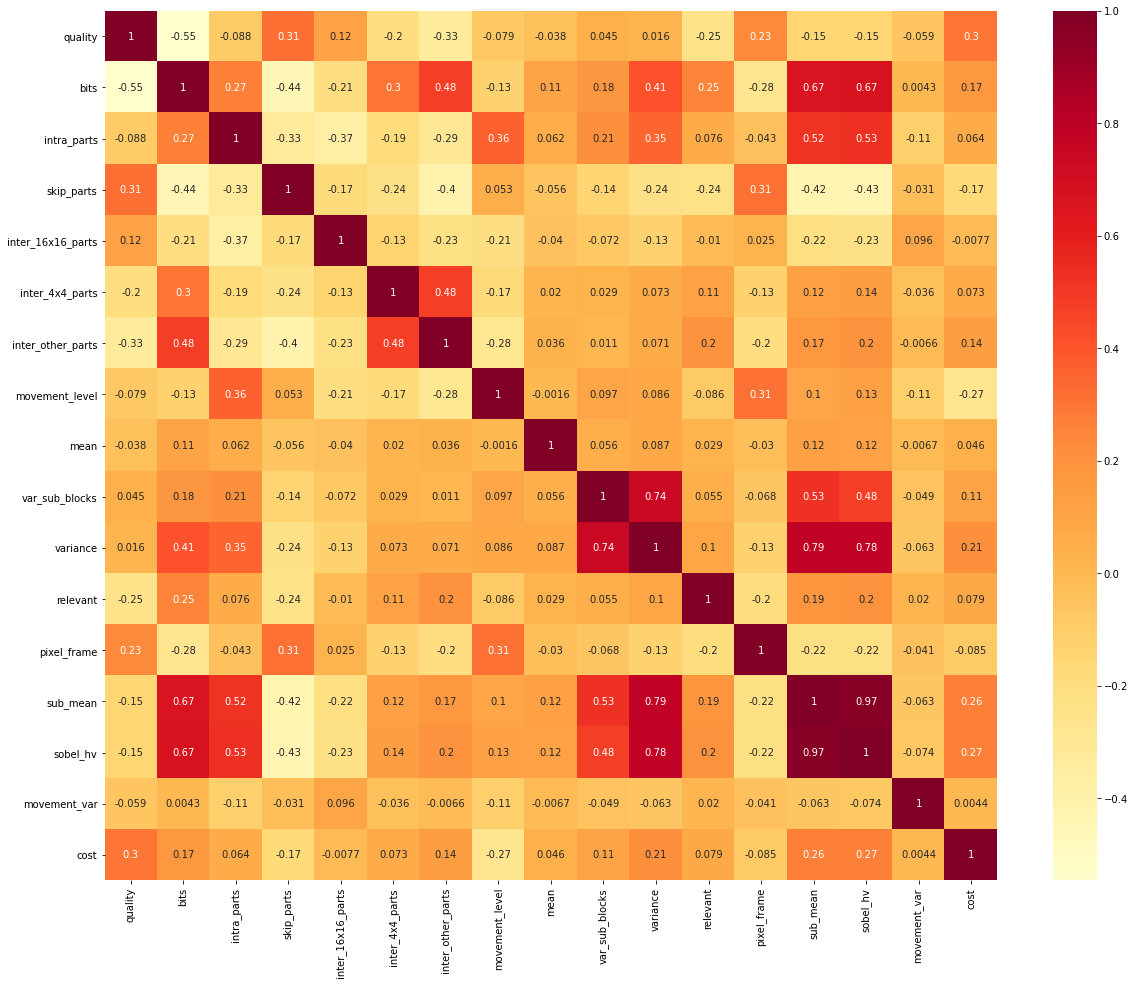

In [25]:
plt.figure(figsize = (20, 16))
corr_mtx = df.corr()
sns.heatmap(corr_mtx, annot = True, cmap = "YlOrRd")

The analysis is not finished since some variables still having high correlation between them and have a low correlation with the target variable (relevant). A low correlation is considered when the absolute value it is lower than 0.02. Due that we have chosen movement_var, sub_mean, var_sub_blocks and inter_16x16_parts.
Finally, we have decided to drop the variable mean for its high correlation with other variables, as we can see for instance with sobel (0.97), variance (0.79) or bits (0.67).

In [26]:
df = df.drop(["movement_var", "sub_mean", "var_sub_blocks", "inter_16x16_parts", "mean"], axis = 1)

Now we generate the correlation matrix showing the improvement of the results for the target variable.

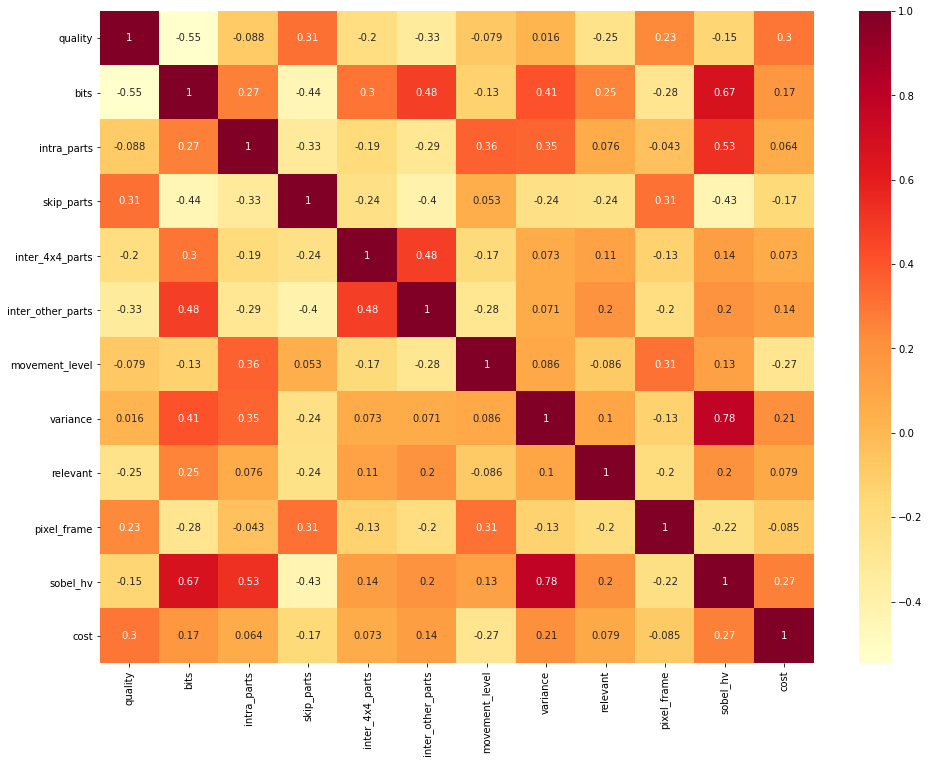

In [27]:
plt.figure(figsize = (16, 12))
corr_mtx = df.corr()
sns.heatmap(corr_mtx, annot = True, cmap = "YlOrRd")

Now we can check if the continuous variables that are still in the analysis are statistically different or if they have the same mean.

In [28]:
cont = df.loc[:, df.nunique() >= 29]
varlist = cont.columns.tolist()
varlist.append('relevant')
contRelv = df[varlist]
equality_testing(contRelv, ["bits","movement_level","variance","pixel_frame", "cost", "sobel_hv"], contRelv.columns[-1])

bits
The groups are different.
movement_level
The groups are different.
variance
The groups are different.
pixel_frame
The groups are different.
cost
The groups are different.
sobel_hv
The groups are different.


/Users/nacho/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:5770: RuntimeWarning: invalid value encountered in subtract
  d = (a - b).astype(np.float64)
/Users/nacho/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/Users/nacho/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


(array([1.0923e+04, 2.7110e+03, 1.3170e+03, 6.1500e+02, 2.5000e+02,
        8.9000e+01, 5.4000e+01, 2.3000e+01, 7.0000e+00, 9.0000e+00]),
 array([   0. ,  477.1,  954.2, 1431.3, 1908.4, 2385.5, 2862.6, 3339.7,
        3816.8, 4293.9, 4771. ]),
 <a list of 10 Patch objects>)

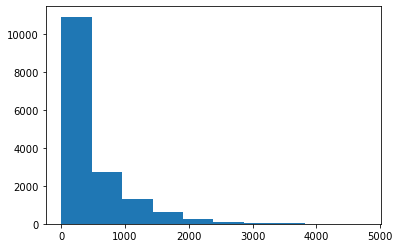

In [29]:
plt.hist(cont.bits)

(array([7998.,    0., 1436.,  651.,  972.,  941.,    0.,    0., 2757.,
        1243.]),
 array([   31645. ,  1256140.8,  2480636.6,  3705132.4,  4929628.2,
         6154124. ,  7378619.8,  8603115.6,  9827611.4, 11052107.2,
        12276603. ]),
 <a list of 10 Patch objects>)

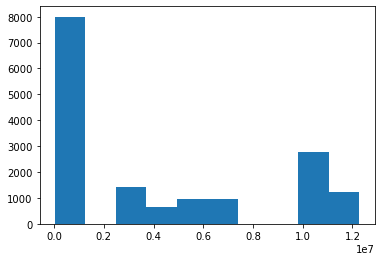

In [30]:
plt.hist(cont.movement_level)

(array([1.4886e+04, 8.0000e+02, 2.2000e+02, 5.0000e+01, 2.3000e+01,
        7.0000e+00, 7.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0.       ,  202.2197998,  404.4395996,  606.6593994,
         808.8791992, 1011.098999 , 1213.3187988, 1415.5385986,
        1617.7583984, 1819.9781982, 2022.197998 ]),
 <a list of 10 Patch objects>)

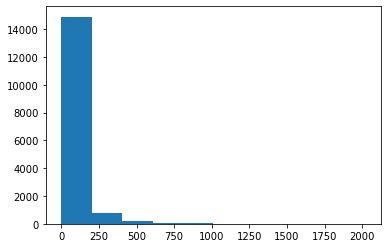

In [31]:
plt.hist(cont.variance)

/Users/nacho/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/nacho/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.0328e+04, 3.2950e+03, 1.5090e+03, 5.7400e+02, 1.9900e+02,
        4.5000e+01, 2.5000e+01, 4.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([     0.  ,  39856.95,  79713.9 , 119570.85, 159427.8 , 199284.75,
        239141.7 , 278998.65, 318855.6 , 358712.55, 398569.5 ]),
 <a list of 10 Patch objects>)

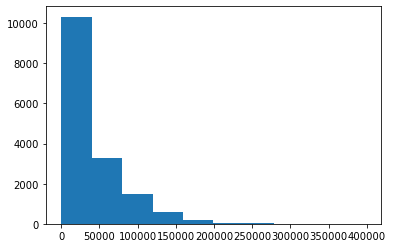

In [32]:
plt.hist(cont.cost)

(array([8785., 3624., 1672.,  908.,  503.,  296.,  117.,   48.,   35.,
          10.]),
 array([ 0.       ,  6.3519531, 12.7039062, 19.0558593, 25.4078124,
        31.7597655, 38.1117186, 44.4636717, 50.8156248, 57.1675779,
        63.519531 ]),
 <a list of 10 Patch objects>)

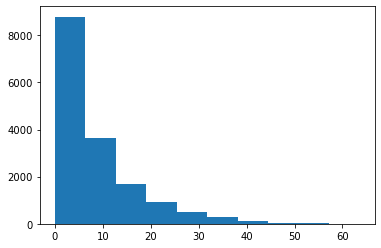

In [33]:
plt.hist(cont.sobel_hv)

We normalize the data in order to perform models

In [34]:
std_cont = preprocessing.scale(cont)

ValueError: Input contains infinity or a value too large for dtype('float64').

We decided to use the Label encoder instead of the One Hot Encoding as order could be important for further analysis.

In [36]:
l_code = LabelEncoder()
for var in cat.columns:
    l_code.fit(cat[var])
    cat[var] = l_code.transform(cat[var])